# Capstone - Comparing ML models for single-label text classification (Part 4)

**Table of Contents**
<div id="toc"></div>

## Problem statement, goals and success criteria

Text Classification techniques are necessary to find relevant information in many different tasks that deal with large quantities of information in text form.  Some of the most common tasks where these techniques are applied include: finding answers to similar questions that have been answered before; classifying news by subject or newsgroup; sorting spam from legitimate e-mail messages; finding web pages on a given subject, among others. In each case, the goal is to assign the appropriate class or label to each document that needs to be classified.

Depending on the application, documents can be classified into one or more classes.  For instance, a piece of news regarding how the Prime Minister spent his holidays may be classified both as politics and in the social column.  In other situations, however, documents can have only one classification, for example, when distinguishing between spam and legitimate e-mail messages.  The focus of this work is where each document belongs to a single class, that is, single-label classification.

I will use multiple Machine Learning models and compare how well they perform on single-label text classification tasks using some well known public datasets that are actively used for research.

The main goal is to reproduce part of my PhD work using state-of-the-art libraries in Python (sklearn, matplotlib, seaborn), and be able to assess how this area evolved in the past 10 years.

I consider this work will be successful if I am able to reproduce the initial "related work" from my thesis, which at the time took over one year to complete, for this capstone project.  I expect results to be approximately the same as previously published results, and I will even apply some Machine Learning models that I did not use at the time, but that are currently available in the libraries I will use.

## Explain data and run statistical analysis

There are many datasets that are actively used for research in text categorisation.  The reason to have "standard" datasets available for research is to facilitate the comparison of results from different algorithms and different researchers.  Some of these datasets already have a pre-defined train/test split, once more to facilitate comparison of results across different settings.  I chose to use three of the datasets publicly available, with the pre-defined train/test split for each one of them.  The datasets were available as .csv files from [this webpage](http://ana.cachopo.org/datasets-for-single-label-text-categorization).

### 20 Newsgroups

The 20Newsgroups dataset originated from Jason Rennie's page and is a collection of approximately 20,000 newsgroup documents, partitioned (nearly) evenly across 20 different newsgroups.  In this work I will use the "bydate" version, because it already had a standard train/test split.

### Reuters-21578

The Reuters-21578 dataset originated from from David Lewis' page and is a collection of documents that appeared on the Reuters newswire in 1987 and were manually classified by personnel from Reuters Ltd.  In this work I will use the standard "modApté" train/test split.

Due to the fact that the class distribution for these documents is very skewed, two sub-collections are usually considered for text classification tasks:

- R10 - The set of the 10 classes with the highest number of positive training examples.
- R90 - The set of the 90 classes with at least one positive training and testing example.

Moreover, many of these documents are classified as having no topic at all or with more than one topic.  As the goal in this work is to consider single-labeled datasets, all the documents with less than one or with more than one topic were eliminated. With this, some of the classes in R10 and R90 were left with no train or test documents.

Considering only the documents with a single topic and the classes which still have at least one train and one test example, we are left with 8 of the 10 most frequent classes and 52 of the original 90.

Following the usual convention, I will call these sets R8 and R52.  Note that from R10 to R8 the classes 'corn' and 'wheat', which are intimately related to the class 'grain' disapeared and this last class lost many of its documents (because they had multiple labels).

### Load files and check numbers of documents per class

The first step is to read all the files and check that the number of documents in each class matches what was previously published.  Looking at the `xxx_counts` dataframes below and comparing them with the tables in [this webpage](http://ana.cachopo.org/datasets-for-single-label-text-categorization), we can see that they match.

In [21]:
from __future__ import division, print_function, unicode_literals
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [22]:
def read_file(filename):
    """Reads one csv file without header and two columns separated by a TAB"""
    return pd.read_csv("./datasets/"+filename, 
                       header=None, sep='\t', 
                       names=['label', 'text'])

In [23]:
ng20_train_df = read_file('ng20-train-all-terms.txt')
ng20_test_df = read_file('ng20-test-all-terms.txt')
r52_train_df = read_file('r52-train-all-terms.txt')
r52_test_df = read_file('r52-test-all-terms.txt')
r8_train_df = read_file('r8-train-all-terms.txt')
r8_test_df = read_file('r8-test-all-terms.txt')

all_dfs = [ng20_train_df, ng20_test_df, 
           r52_train_df, r52_test_df, 
           r8_train_df, r8_test_df]

all_df_names = ["ng20_train_df", "ng20_test_df", 
                "r52_train_df", "r52_test_df", 
                "r8_train_df", "r8_test_df"]

# check that all files were read by printing the shape
# of the resulting dataframe and the first document
for (df, name) in zip(all_dfs, all_df_names):
    print(name, "(#rows, #columns):", df.shape)
    print(df.head(1))

ng20_train_df (#rows, #columns): (11293, 2)
         label                                               text
0  alt.atheism  alt atheism faq atheist resources archive name...
ng20_test_df (#rows, #columns): (7528, 2)
         label                                               text
0  alt.atheism  re about the bible quiz answers in article hea...
r52_train_df (#rows, #columns): (6532, 2)
   label                                               text
0  cocoa  bahia cocoa review showers continued throughou...
r52_test_df (#rows, #columns): (2568, 2)
   label                                               text
0  trade  asian exporters fear damage from u s japan rif...
r8_train_df (#rows, #columns): (5485, 2)
  label                                               text
0  earn  champion products ch approves stock split cham...
r8_test_df (#rows, #columns): (2189, 2)
   label                                               text
0  trade  asian exporters fear damage from u s japan rif...


In [24]:
def create_counts_df(df_train, df_test):
    """Receives two dataframes with train and test documents
    and returns a dataframe with the number of train, 
    test and total documents per class.
    Assumes both dataframes have the same classes."""
    counts_df = pd.concat([df_train["label"].value_counts(), 
                           df_test["label"].value_counts()], 
                          axis=1, keys=["# train docs", "# test docs"])
    counts_df["total # docs"] = counts_df.sum(axis=1)
    counts_df.loc["Total"] = counts_df.sum()
    return counts_df

In [25]:
ng20_counts = create_counts_df(ng20_train_df, ng20_test_df)
ng20_counts

,# train docs,# test docs,total # docs
alt.atheism,480,319,799
comp.graphics,584,389,973
comp.os.ms-windows.misc,572,394,966
comp.sys.ibm.pc.hardware,590,392,982
comp.sys.mac.hardware,578,385,963
comp.windows.x,593,392,985
misc.forsale,585,390,975
rec.autos,594,395,989
rec.motorcycles,598,398,996
rec.sport.baseball,597,397,994


In [26]:
r52_counts = create_counts_df(r52_train_df, r52_test_df)
r52_counts

,# train docs,# test docs,total # docs
acq,1596,696,2292
alum,31,19,50
bop,22,9,31
carcass,6,5,11
cocoa,46,15,61
coffee,90,22,112
copper,31,13,44
cotton,15,9,24
cpi,54,17,71
cpu,3,1,4


In [27]:
r8_counts = create_counts_df(r8_train_df, r8_test_df)
r8_counts

,# train docs,# test docs,total # docs
acq,1596,696,2292
crude,253,121,374
earn,2840,1083,3923
grain,41,10,51
interest,190,81,271
money-fx,206,87,293
ship,108,36,144
trade,251,75,326
Total,5485,2189,7674


### Exploratory data analysis (EDA)

#### Plot numbers of train and test documents per class for each dataset

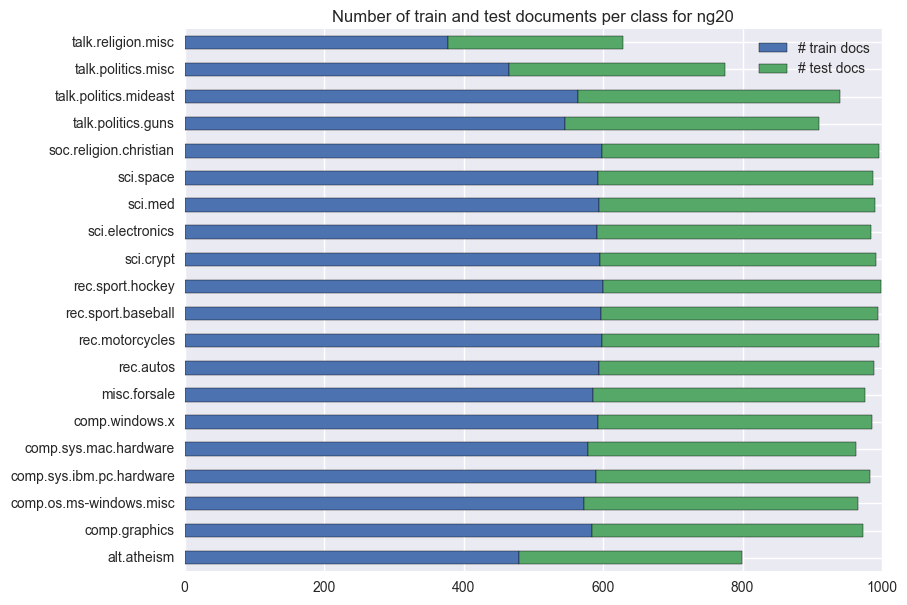

In [28]:
# do not plot totals (last column, last row in counts dataframes)
ng20_counts.iloc[:-1,:-1].plot.barh(stacked=True, 
                                    figsize=(9, 7),
                                    title="Number of train and test documents per class for ng20")

The number of train and test documents is approximately ballanced for all the classes in the `ng20` dataset.  Also, there's the usual 2/3 1/3 train/test split.

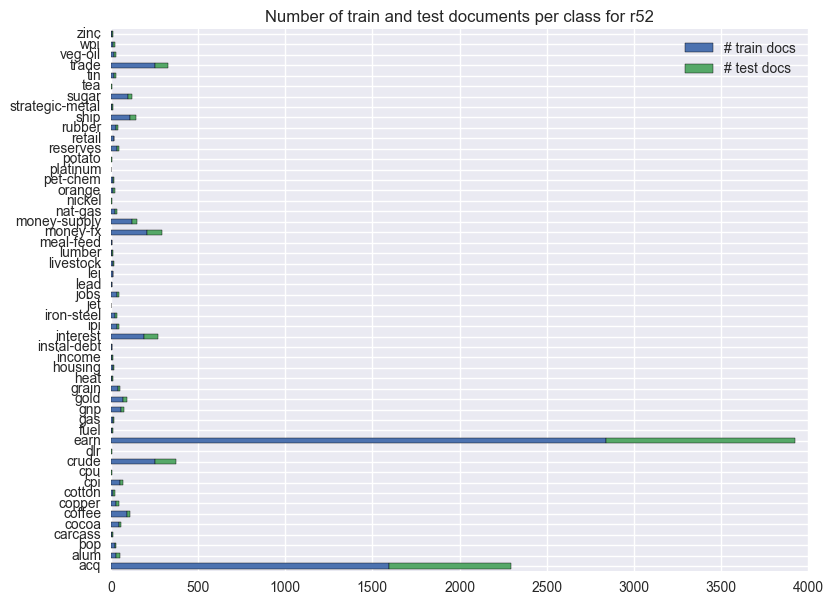

In [29]:
# do not plot totals (last column, last row in counts dataframes)
r52_counts.iloc[:-1,:-1].plot.barh(stacked=True, 
                                   figsize=(9, 7),
                                   title="Number of train and test documents per class for r52")

The class distribution for the documents in the Reuters  dataset is very skewed, with the two most frequent classes containing approximately 70% of all the documents.  Also, even within each class, there's nolonger the usual 2/3 1/3 train/test split.

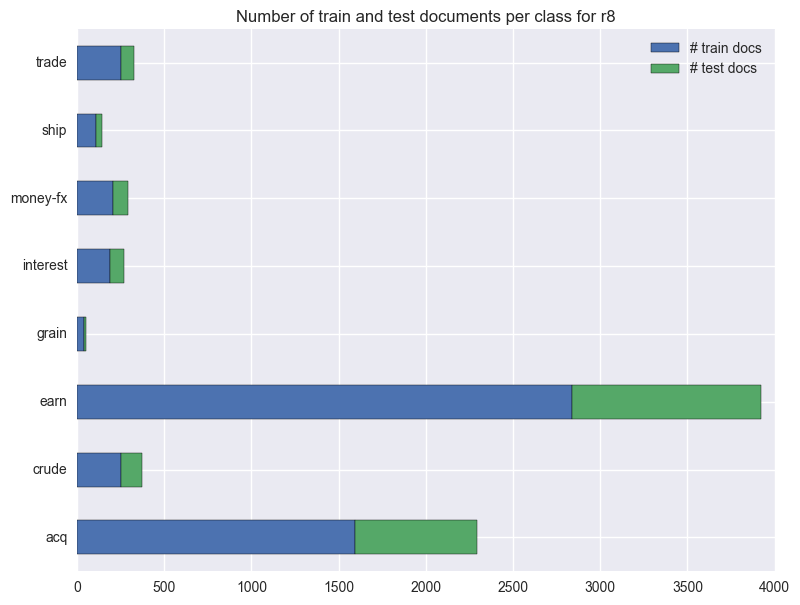

In [30]:
# do not plot totals (last column, last row in counts dataframes)
r8_counts.iloc[:-1,:-1].plot.barh(stacked=True, 
                                  figsize=(9, 7), 
                                  title="Number of train and test documents per class for r8")

Even considering only the 8 most frequent classes, the two most frequent classes in this dataset now account for approximately 80% of all the documents.   Also, even within each class, there's nolonger the usual 2/3 1/3 train/test split.

#### Count numbers of features for each dataset

Use `CountVectorizer` to extract the words used in each training set.  I use only the training set because that's what the ML models will be able to use in the training phase.  The test set is only used for testing, so it should not be used to determine the set of features.

In [31]:
from sklearn.feature_extraction.text import CountVectorizer

def describe_dataset(name, df_train):
    print("Dataset:", name)

    # consider all words
    cvec = CountVectorizer()
    cvec.fit(df_train["text"])
    with_stop = len(cvec.get_feature_names())
    print("Number of features including stopwords:", with_stop)

    # remove english stopwords
    cvec = CountVectorizer(stop_words="english")
    cvec.fit(df_train["text"])
    without_stop = len(cvec.get_feature_names())
    print("Number of features excluding stopwords:", without_stop)
    
    print("Difference in number of features:", with_stop-without_stop)
    return with_stop, without_stop

In [32]:
ng20_with_stop, ng20_without_stop = describe_dataset("ng20", ng20_train_df)

Dataset: ng20
Number of features including stopwords: 73686
Number of features excluding stopwords: 73375
Difference in number of features: 311


In [33]:
r52_with_stop, r52_without_stop = describe_dataset("r52", r52_train_df)

Dataset: r52
Number of features including stopwords: 22248
Number of features excluding stopwords: 21969
Difference in number of features: 279


In [34]:
r8_with_stop, r8_without_stop = describe_dataset("r8", r8_train_df)

Dataset: r8
Number of features including stopwords: 19956
Number of features excluding stopwords: 19679
Difference in number of features: 277


It's interesting to note that different datasets use different numbers of stopwords, and datasets with more features also tend to use more stopwords.

The number of stopwords (around 300) is small relatively to the total number of features (20k for the smallest dataset), so we can simply compare the total number of features for these datasets in the folowing plot.

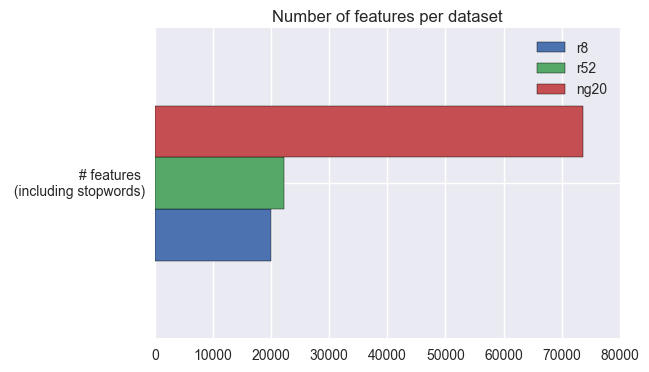

In [35]:
features_df = pd.DataFrame({"ng20": [ng20_with_stop],
                            "r52": [r52_with_stop],
                            "r8": [r8_with_stop]},
                           index=["# features \n (including stopwords)"])
features_df[["r8","r52","ng20"]].plot.barh(title="Number of features per dataset")

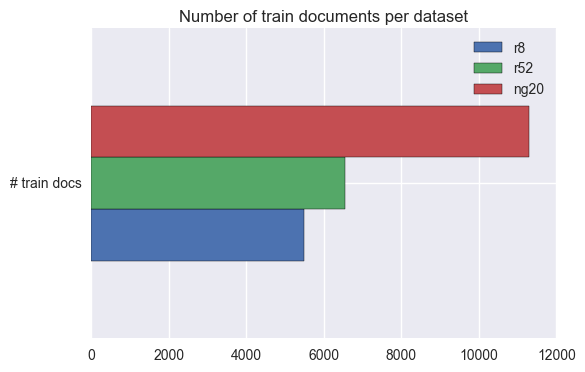

In [36]:
train_docs_df = pd.DataFrame({"ng20": ng20_counts.loc["Total"]["# train docs"],
                              "r52": r52_counts.loc["Total"]["# train docs"],
                              "r8": r8_counts.loc["Total"]["# train docs"]},
                             index=["# train docs"])
train_docs_df[["r8","r52","ng20"]].plot.barh(title="Number of train documents per dataset")

From the last two plots together, we can see that:

- The 20Newsgroups dataset has a much bigger vocabulary than either of the Reuters datasets.
- Because `r8` is a subset of `r52`, it has a smaller vocabulary (this was to be expected), but not much smaller.
- Even though the number of train documents does not even double from `r52` to `ng20`, the number of features (or different words) more than triples.  We can conjecture that people use more words when they are freely posting to newsgroups than when they are writing newswire articles.

#### Determine most common words for each dataset

Here I will create two csv files for each dataset, one before and one after removing stopwords.  The files will contain the most common words in the dataset (once more, considering only the training set).  It should be interesting to see if the most common words change significantly  by removing english stopwords.  Stopwords are very common words in a language, that appear frequently in texts, but that do not have a high discriminative power.  Examples of stopwords in english are "the", "to", and "and".

In [37]:
from sklearn.feature_extraction.text import CountVectorizer

def create_word_counts_csv(docs, out_file, stopwords=None):
    """Creates a csv file with word counts for 50 most
    frequent words in the docs.
    Is *inefficient* because it creates a dense matrix, 
    but only needs to be used once for each dataset."""
    cvec = CountVectorizer(stop_words=stopwords)
    cvec.fit(docs)

    df = pd.DataFrame(cvec.transform(docs).todense(),
                      columns=cvec.get_feature_names())

    df_word_counts = df.sum(axis=0)
    df_word_counts.sort_values(ascending=False, inplace=True)
    df_word_counts[:50].to_csv(out_file)

The next three cells do not need to be run after the initial creation of the csv files for each dataset.  They take a long time and use a significant amount of memory, because I am creating a dense matrix, then creating a dataframe and then using it to count the most frequent words in each dataset.  I did not worry about optimising this, because it will only be run once to perform the initial EDA.

I turned the cell type to "raw", so that I can run all cells in this notebook and not waste time defining variables that will not be used anywhere else.  Turn the cell type to "code" if they are to be run again.

#### Create word clouds (using Tableau) for each dataset

This is how to create a word cloud in Tableau, from a csv that is a two-column table with a list of the unique words in the first column [Words] and their frequencies in the second column [Word Count]:

1. Open the file with Tableau.
2. Drag [Words] to the Text Control of the Marks Shelf.
3. Drag [Word Count] to the Size Control of the Marks Shelf.
4. Change the Marks Type from Automatic to Text.
5. To color the Word Cloud, drag [Words] to the Colors Control of the Marks Shelf.

<tr>
<td> ![png](./fig-ng20-incl-stop.png) </td>
<td> ![png](./fig-ng20-excl-stop.png) </td>
</tr>
<tr>
<td> ![png](./fig-r52-incl-stop.png) </td>
<td> ![png](./fig-r52-excl-stop.png) </td>
</tr>
<tr>
<td> ![png](./fig-r8-incl-stop.png) </td>
<td> ![png](./fig-r8-excl-stop.png) </td>
</tr>

These word clouds look nice, but that's not the only reason why they are here.  By looking at them we can take some valuable insights:

- I labeled each word cloud with the dataset, but I did not indicate if it was before or after removing stopwords.  We can easily see that the in the left column all clouds contain big words like "the", "to", "of". These words do not bring much to the meaning of a sentence, and they do not appear in the clouds in the right.  The clouds in the right are the ones obtained after removing stopwords.
- After removing stopwords (clouds in the right column), word sizes are more uniform (as are word counts).
- Words in the `ng20` and `r*` clouds are very different.  This can be attributed to these datasets being about different subjects.
- Words in the `r52` and `r8` clouds are more similar.  This can be attributed to `r8` being a subset of `r52`, thus about some of the same subjects.

## Apply different models to data 

Here I start by reproducing (as closely as possible) some of the previously published results for these datasets.  I then work on improving those results by using different models, or features, or optimising model parameters.  I use the standard train and test splits for these datasets, so that these results are comparable to others: train using the train set (eventually using cross-validation), evaluate using the test set (which was not seen by the model before).

### Reproduce previous results for these datasets

The first goal is to be able to reproduce previously published results for these datasets.  I will apply the ML models mentioned in the [webpage from where I got the data](http://ana.cachopo.org/datasets-for-single-label-text-categorization).  We can see a summary of those results in the following table.  This table includes two datasets that are not used in this work, because they are not as well known in the literature (WebKB and Cade12).

![png](./fig-results-initial-webpage.png)

In [38]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

from sklearn.metrics import confusion_matrix, accuracy_score

In [39]:
def to_tfidf(df_train, df_test):
    """Receives the train and test dataframes (columns: label, text) and 
    returns the X_train, y_train, X_test, y_test necessary to fit the models.
    The X_train and X_test feature matrices contain tfidf values."""
    vec = TfidfVectorizer(stop_words='english', smooth_idf=False)
    vec.fit(df_train["text"])
    X_train = vec.transform(df_train["text"])
    y_train = df_train["label"]
    X_test = vec.transform(df_test["text"])
    y_test = df_test["label"]
    return X_train, y_train, X_test, y_test
    
def apply_model(model, X_train, y_train, X_test, y_test):
    """Returns the Accuracy score of fitting the model with
    the train data and predicting for the test data."""
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    score = accuracy_score(y_test, y_pred)
    return score

def apply_models(models, df_train, df_test, use_lsi=False):
    """Returns a list of (model_name, accuracy) that results from 
    applying each model to the train and test dataframes.
    use_lsi indicates if it should be applied to the documents features
    before using the model; default False."""
    X_train, y_train, X_test, y_test = to_tfidf(df_train, df_test)
    if use_lsi:
        svd = TruncatedSVD(n_components=200, random_state=42)
        X_train = svd.fit_transform(X_train)
        X_test = svd.transform(X_test)

    return [(name, apply_model(model, X_train, y_train, X_test, y_test)) \
            for (name, model) in models]

#### Difficulties encountered when trying to reproduce previous work

- The implementation of tfidf feature selection is not the same, because sklearn uses smoothing and my initial implementation did not.  This fact alone will lead to different results in all models that use these features for classification.
- Not all previous models have a direct implementation in sklearn, so for some of them I had to choose the most similar model that I could find in sklearn, and expect results to be different.
- This is a very short description of the ML models that were used and how they were implemented here, if there was not a direct way of doing so:

    - The "Dumb Classifier" determines the class of a test document by finding the most frequent class in the train set and returning it every time.
    - The "Vector Method" determines the class of a test document by finding the most similar train document (using cosine similarity) and returning its class.  It was implemented in this work by using kNN, where the number of "neighbours" to consider is 1.
    - The "kNN (k=10)" method determines the class of a test document by finding the k most similar train documents (using cosine similarity) and returning the most frequent class in those documents.
    - The "Centroid" method determines the class of a test document by finding the most similar centroid and returning its class.  In sklearn this method calculates one centroid for each class by determining the mean of all the documents in that class.  In my thesis, I calculated the centroid for each class by determining the sum of all the documents in that class and normalising it to unitary length.
    - The "Naive Bayes" method determines the class of a test document as the most likely class given the document's terms.
    - The "SVM (Linear Kernel)" method determines the class of a test document by projecting it into a high-dimensional hyperspace and determining wich class corresponds to the "hyperpoint" it was projected into.

In [40]:
webpage_models = (
    ("Dumb Classifier", DummyClassifier(strategy="most_frequent")),
    ("Vector Method", KNeighborsClassifier(n_neighbors=1)),
    ("KNN (k=10)", KNeighborsClassifier(n_neighbors=10)),
    ("Centroid", NearestCentroid()),
    ("Naive Bayes", MultinomialNB(fit_prior=False)),
    ("SVM (Linear Kernel)", LinearSVC()),
)

In [41]:
r8_results = apply_models(webpage_models, r8_train_df, r8_test_df)
r8_results

[(u'Dumb Classifier', 0.49474645957058017),
 (u'Vector Method', 0.8332571950662403),
 (u'KNN (k=10)', 0.89904065783462772),
 (u'Centroid', 0.894015532206487),
 (u'Naive Bayes', 0.94243947007766105),
 (u'SVM (Linear Kernel)', 0.9730470534490635)]

In [42]:
r52_results = apply_models(webpage_models, r52_train_df, r52_test_df)
r52_results

[(u'Dumb Classifier', 0.42172897196261683),
 (u'Vector Method', 0.80685358255451711),
 (u'KNN (k=10)', 0.86526479750778817),
 (u'Centroid', 0.85708722741433019),
 (u'Naive Bayes', 0.84073208722741433),
 (u'SVM (Linear Kernel)', 0.94937694704049846)]

In [43]:
ng20_results = apply_models(webpage_models, ng20_train_df, ng20_test_df)
ng20_results

[(u'Dumb Classifier', 0.05300212539851222),
 (u'Vector Method', 0.72170563230605733),
 (u'KNN (k=10)', 0.74521785334750268),
 (u'Centroid', 0.75345377258235924),
 (u'Naive Bayes', 0.82213071200850163),
 (u'SVM (Linear Kernel)', 0.84710414452709881)]

In [44]:
webpage_results_df = pd.DataFrame({"r8": [result[1] for result in r8_results],
                                   "r52": [result[1] for result in r52_results],
                                   "ng20": [result[1] for result in ng20_results]},
                                  index=[model[0] for model in webpage_models])
webpage_results_df[["r8","r52","ng20"]] # match dataset order (columns) in webpage

,r8,r52,ng20
Dumb Classifier,0.494746,0.421729,0.053002
Vector Method,0.833257,0.806854,0.721706
KNN (k=10),0.899041,0.865265,0.745218
Centroid,0.894016,0.857087,0.753454
Naive Bayes,0.942439,0.840732,0.822131
SVM (Linear Kernel),0.973047,0.949377,0.847104


By analising the previous code, reading the description of the models used in the webpage and in sklearn, and looking at both the webpage results and the present work results syde by side, we can observe a few interesting things that led to the results not being the same in both tables.

<tr>
<td> ![png](./fig-results-initial-webpage.png) </td>
<td>  </td>
<td> ![png](./fig-results-initial-present.png) </td>
</tr>

Actually, it's simpler to visualise if I plot the differences in Accuracy between the present results and the results in the webpage for each dataset and ML model.

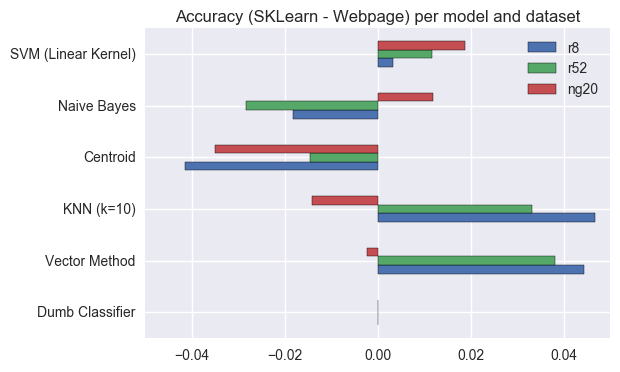

In [45]:
# Accuracy values copied from the table on the webpage by hand
old_results = {"r8"  : [0.4947, 0.7889, 0.8524, 0.9356, 0.9607, 0.9698],
               "r52" : [0.4217, 0.7687, 0.8322, 0.8717, 0.8692, 0.9377],
               "ng20": [0.0530, 0.7240, 0.7593, 0.7885, 0.8103, 0.8284]}

webpage_old_results_df = pd.DataFrame(old_results,
                                      index=[model[0] for model in webpage_models])

#print(webpage_results_df[["r8","r52","ng20"]])
#print(webpage_old_results_df[["r8","r52","ng20"]])

webpage_results_diffs_df = (webpage_results_df[["r8","r52","ng20"]] - 
                            webpage_old_results_df[["r8","r52","ng20"]])
webpage_results_diffs_df[["r8","r52","ng20"]].plot.barh(title="Accuracy (SKLearn - Webpage) per model and dataset")

By observing this plot we can see that there are some Accuracy differences between the results obtained now and the results that were in the webpage (the largest difference is less than 5%).  Most of the differences can be attributed to the different algorithms to calculate tfidf, but it is still worth noting that:

- The "Dumb Classifier" has the same results for all datasets in both settings because it only uses the document's class (or label) for classification. (If this was not the case, something would be very wrong!)
- The "Centroid" method has very different implementations in sklearn and my thesis, and the one in my thesis is consistently better for all datasets. (Maybe my way of calculating the centroids should be incorporated into sklearn.)
- The new tfidf implementation affects results, but not always for the better.  It also seems to affect ng20 and r* datasets in different ways, because when one of them improves the other worsens and vice versa (except for Centroid and SVM).
- The dataset that seems to be less affected by the new way to calculate tfidf is the ng20, where all Accuracy differences are less than 2% (except for Centroid).
- Both r8 and r52 are affected in a similar way for each model.  This makes sense, because they were both derived from the same initial dataset, so they should have similar characteristics.

###  Use LSI (Latent Semantic Indexing) to improve results

Part of my thesis work was using LSI to reduce the dimensionality of the datasets, while at the same time hoping to improve Accuracy of the results.

At the time, I used LSI alone and combined with kNN, Centroid and SVM and observed that results improved in general, but not when combining LSI and SVM.  I will compare LSI with the vector method, because it applies the same model, but to different feature vectors.

Now, I will reproduce part of that work and see if I obtain similar results using sklearn.

In [46]:
lsi_models = (("Dumb Classifier", DummyClassifier(strategy="most_frequent")),
              ("LSI Method", KNeighborsClassifier(n_neighbors=1)),
              ("KNN-LSI (k=10)", KNeighborsClassifier(n_neighbors=10)),
              ("Centroid-LSI", NearestCentroid()),
              ("SVM-LSI (Linear Kernel)", LinearSVC()),
             )
# It does not make sense to use LSI with Bayesian models.
# Dumb classifier should give exactely same results because it only considers 
# class information.

In [47]:
r8_results_lsi = apply_models(lsi_models, r8_train_df, r8_test_df, use_lsi=True)
r8_results_lsi

[(u'Dumb Classifier', 0.49474645957058017),
 (u'LSI Method', 0.9346733668341709),
 (u'KNN-LSI (k=10)', 0.94106898126998628),
 (u'Centroid-LSI', 0.89310187300137045),
 (u'SVM-LSI (Linear Kernel)', 0.96984924623115576)]

In [48]:
r52_results_lsi = apply_models(lsi_models, r52_train_df, r52_test_df, use_lsi=True)
r52_results_lsi

[(u'Dumb Classifier', 0.42172897196261683),
 (u'LSI Method', 0.88473520249221183),
 (u'KNN-LSI (k=10)', 0.87772585669781933),
 (u'Centroid-LSI', 0.82904984423676009),
 (u'SVM-LSI (Linear Kernel)', 0.9240654205607477)]

In [49]:
ng20_results_lsi = apply_models(lsi_models, ng20_train_df, ng20_test_df, use_lsi=True)
ng20_results_lsi

[(u'Dumb Classifier', 0.05300212539851222),
 (u'LSI Method', 0.62061636556854405),
 (u'KNN-LSI (k=10)', 0.63270456960680133),
 (u'Centroid-LSI', 0.70257704569606805),
 (u'SVM-LSI (Linear Kernel)', 0.79051540913921359)]

In [50]:
lsi_results_df = pd.DataFrame({"r8": [result[1] for result in r8_results_lsi],
                               "r52": [result[1] for result in r52_results_lsi],
                               "ng20": [result[1] for result in ng20_results_lsi]},
                              index=[model[0] for model in lsi_models])
lsi_results_df[["r8","r52","ng20"]]

,r8,r52,ng20
Dumb Classifier,0.494746,0.421729,0.053002
LSI Method,0.934673,0.884735,0.620616
KNN-LSI (k=10),0.941069,0.877726,0.632705
Centroid-LSI,0.893102,0.829050,0.702577
SVM-LSI (Linear Kernel),0.969849,0.924065,0.790515


In [51]:
webpage_results_df[["r8","r52","ng20"]]

,r8,r52,ng20
Dumb Classifier,0.494746,0.421729,0.053002
Vector Method,0.833257,0.806854,0.721706
KNN (k=10),0.899041,0.865265,0.745218
Centroid,0.894016,0.857087,0.753454
Naive Bayes,0.942439,0.840732,0.822131
SVM (Linear Kernel),0.973047,0.949377,0.847104


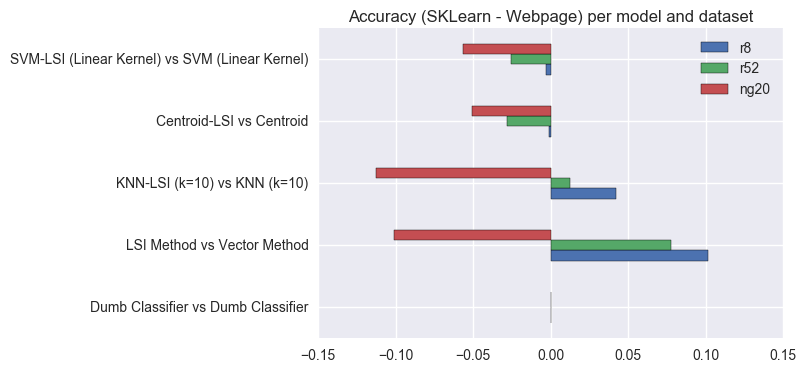

In [52]:
# including Dumb Classifier just to check that it does not change
lsi_models_correspondence = (("Dumb Classifier", "Dumb Classifier"),
                             ("LSI Method", "Vector Method"),
                             ("KNN-LSI (k=10)", "KNN (k=10)"),
                             ("Centroid-LSI", "Centroid"),
                             ("SVM-LSI (Linear Kernel)", "SVM (Linear Kernel)"),
                            )

results = []
for (name1, name2) in lsi_models_correspondence:
    results.append(lsi_results_df.loc[name1][["r8","r52","ng20"]] - 
                   webpage_results_df.loc[name2][["r8","r52","ng20"]])

lsi_results_diffs_df = pd.DataFrame(results,
                                    index=[model[0]+" vs "+model[1] for 
                                           model in lsi_models_correspondence])

lsi_results_diffs_df[["r8","r52","ng20"]].plot.barh(title="Accuracy (SKLearn - Webpage) per model and dataset")

We can see that using LSI to reduce the dimensionality of the dataset improves results for the r* datasets, but not for ng20, when using "simple" ML models like Vector or kNN.  Also, models that already greatly change the initial dataset (SVM by changing dimensions; Centroid by using a single vector to represent an entire class) get worse results when combined with a further dimensionality reduction.

###  Use more ML models

After reproducing some of the results from my thesis, I decided to apply other ML models that I had not used at the time, to see if I could improve results using some of the models available in sklearn.

In [53]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.svm import LinearSVC

from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score

In [54]:
many_models = (("Dumb Classifier", DummyClassifier(strategy="most_frequent")),
                ("KNN", KNeighborsClassifier()),
                ("Centroid", NearestCentroid()),
                ("Naive Bayes", MultinomialNB()),
                ("SVM (Linear)", LinearSVC()),
                ## "new" models from here
                ("Decision Tree", DecisionTreeClassifier()),
                ("Random Forest", RandomForestClassifier()),
                ("Extra Trees", ExtraTreesClassifier()),
                ("Ada Boost", AdaBoostClassifier()),
                ("Ensemble1", VotingClassifier(estimators=[('KNN', KNeighborsClassifier()), 
                                                          ('Centr', NearestCentroid()), 
                                                          ('DT', DecisionTreeClassifier())])),
                ("Ensemble2", VotingClassifier(estimators=[('KNN', KNeighborsClassifier()), 
                                                          ('Centr', NearestCentroid()), 
                                                          ('DT', DecisionTreeClassifier()),
                                                          ("RF", RandomForestClassifier()),
                                                          ("SVC", LinearSVC())])),
                 )

In [55]:
r8_results_many = apply_models(many_models, r8_train_df, r8_test_df)
r8_results_many

[(u'Dumb Classifier', 0.49474645957058017),
 (u'KNN', 0.86980356327089992),
 (u'Centroid', 0.894015532206487),
 (u'Naive Bayes', 0.85701233439926905),
 (u'SVM (Linear)', 0.9730470534490635),
 (u'Decision Tree', 0.91731384193695753),
 (u'Random Forest', 0.92142530835998171),
 (u'Extra Trees', 0.92325262677021469),
 (u'Ada Boost', 0.84285061671996342),
 (u'Ensemble1', 0.94015532206486985),
 (u'Ensemble2', 0.96116948378254907)]

In [56]:
r52_results_many = apply_models(many_models, r52_train_df, r52_test_df)
r52_results_many

[(u'Dumb Classifier', 0.42172897196261683),
 (u'KNN', 0.83917445482866049),
 (u'Centroid', 0.85708722741433019),
 (u'Naive Bayes', 0.73247663551401865),
 (u'SVM (Linear)', 0.94937694704049846),
 (u'Decision Tree', 0.84423676012461057),
 (u'Random Forest', 0.83995327102803741),
 (u'Extra Trees', 0.8360591900311527),
 (u'Ada Boost', 0.64213395638629278),
 (u'Ensemble1', 0.90342679127725856),
 (u'Ensemble2', 0.92679127725856703)]

In [57]:
ng20_results_many = apply_models(many_models, ng20_train_df, ng20_test_df)
ng20_results_many

[(u'Dumb Classifier', 0.05300212539851222),
 (u'KNN', 0.73352816153028688),
 (u'Centroid', 0.75345377258235924),
 (u'Naive Bayes', 0.81615302869287987),
 (u'SVM (Linear)', 0.84710414452709881),
 (u'Decision Tree', 0.57332624867162596),
 (u'Random Forest', 0.6538257173219979),
 (u'Extra Trees', 0.66219447396386821),
 (u'Ada Boost', 0.49601487778958553),
 (u'Ensemble1', 0.76434643995749207),
 (u'Ensemble2', 0.8202709883103082)]

How do the models compare to the ones before, in terms of Accuracy?

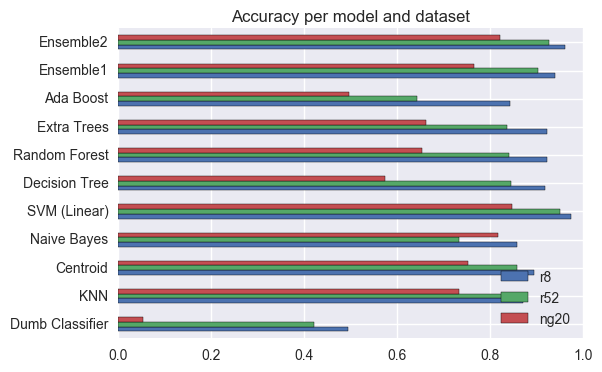

In [58]:
many_results_df = pd.DataFrame({"r8": [result[1] for result in r8_results_many],
                                "r52": [result[1] for result in r52_results_many],
                                "ng20": [result[1] for result in ng20_results_many]},
                               index=[model[0] for model in many_models])
many_results_df[["r8","r52","ng20"]].plot.barh(title="Accuracy per model and dataset")

The idea behind applying new models to the same datasets was to see if it was possible to improve results.  Looking at the previous plot, we can see that

- SVM is still the best model for all datasets.
- The Dumb classifier is still the worst model (included as a baseline).
- AdaBoost and ExtraTrees don't always improve results when compared to DecisionTree.
- Using Ensembles does not improve results a lot in this case.  SVM already behave very well, so even an Ensemble including them does not improve results enough to be interesting in this case.

###  Optimise parameters for some ML models (using GridSearchCV)

In the previous section, all models were used using the default values for their parameters.  Now, I will use GridSearchCV to see if those results can be improved by using different parameters.  I will do so only for the most promising models, due to time constraints.

In [59]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV

from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score

In [60]:
optimisable_models = (
    ("KNN", KNeighborsClassifier(), 
     {"n_neighbors" : [1, 5, 10, 20, 30, 40],
      "weights" : ["uniform", "distance"]}),
    ("Naive Bayes", MultinomialNB(),
     {"alpha" : [0.0, 0.1, 0.25, 0.5, 0.75, 1.0, 2.0], 
      "fit_prior" : [True, False]}),
    ("SVM (Linear)", LinearSVC(), 
     [{"C" : [0.5, 1.0, 2.0, 4.0], "penalty" : ["l2"]},
      {"C" : [0.5, 1.0, 2.0, 4.0], "penalty" : ["l1"], "dual" : [False]}]),
    ("Decision Tree", DecisionTreeClassifier(random_state=42),
     {"criterion" : ["gini", "entropy"],
      "max_features" : [None, 10, "sqrt"], 
      "min_samples_split" : [1, 2, 5, 10], 
      "random_state" : [42]}),
    ("Random Forest", RandomForestClassifier(random_state=42),
     {"n_estimators" : [10, 30, 50, 70], 
      "criterion" : ["gini", "entropy"], 
      "random_state" : [42]}),
)

In [61]:
def apply_grid_models(models, df_train, df_test):
    """Returns two lists: 
    - a list of (model_name, accuracy_bare, accuracy_opt, best_params) 
    that results from applying each model to the train and test 
    dataframes, before and after optimisation using GridSearchCV.
    - a list of (model_name, model_with_best_params) to be used in the 
    next section, to time and compare results from the optimised models."""
    X_train, y_train, X_test, y_test = to_tfidf(df_train, df_test)

    results = []
    optimised_models = []
    for (name, model, params) in models:
        bare_model_score = apply_model(model, X_train, y_train, X_test, y_test)

        gcv = GridSearchCV(model, params)
        gcv.fit(X_train, y_train)
        optimized_score = apply_model(gcv.best_estimator_, X_train, y_train, X_test, y_test)
        results.append((name, bare_model_score, optimized_score, gcv.best_params_))
        
        if optimized_score > bare_model_score:
            optimised_models.append((name, gcv.best_estimator_))
        else:
            optimised_models.append((name, model))
    return results, optimised_models

In [62]:
r8_results_grid, r8_optimised_models  = \
    apply_grid_models(optimisable_models, r8_train_df, r8_test_df)
r8_results_grid

[(u'KNN',
  0.86980356327089992,
  0.89904065783462772,
  {u'n_neighbors': 10, u'weights': u'uniform'}),
 (u'Naive Bayes',
  0.85701233439926905,
  0.95705801735952489,
  {u'alpha': 0.25, u'fit_prior': False}),
 (u'SVM (Linear)',
  0.9730470534490635,
  0.97396071265417994,
  {u'C': 2.0, u'penalty': u'l2'}),
 (u'Decision Tree',
  0.91411603471904979,
  0.91046139789858382,
  {u'criterion': u'gini',
   u'max_features': None,
   u'min_samples_split': 5,
   u'random_state': 42}),
 (u'Random Forest',
  0.9031521242576519,
  0.93969849246231152,
  {u'criterion': u'gini', u'n_estimators': 70, u'random_state': 42})]

In [63]:
r52_results_grid, r52_optimised_models  = \
    apply_grid_models(optimisable_models, r52_train_df, r52_test_df)
r52_results_grid

//anaconda/lib/python2.7/site-packages/sklearn/model_selection/_split.py:579: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


[(u'KNN',
  0.83917445482866049,
  0.86526479750778817,
  {u'n_neighbors': 10, u'weights': u'uniform'}),
 (u'Naive Bayes',
  0.73247663551401865,
  0.88707165109034269,
  {u'alpha': 0.1, u'fit_prior': False}),
 (u'SVM (Linear)',
  0.94937694704049846,
  0.95327102803738317,
  {u'C': 4.0, u'penalty': u'l2'}),
 (u'Decision Tree',
  0.84735202492211836,
  0.84540498442367606,
  {u'criterion': u'gini',
   u'max_features': None,
   u'min_samples_split': 5,
   u'random_state': 42}),
 (u'Random Forest',
  0.82671339563862933,
  0.86915887850467288,
  {u'criterion': u'gini', u'n_estimators': 70, u'random_state': 42})]

In [64]:
ng20_results_grid, ng20_optimised_models  = \
    apply_grid_models(optimisable_models, ng20_train_df, ng20_test_df)
ng20_results_grid

[(u'KNN',
  0.73352816153028688,
  0.75571200850159403,
  {u'n_neighbors': 20, u'weights': u'distance'}),
 (u'Naive Bayes',
  0.81615302869287987,
  0.8387353878852285,
  {u'alpha': 0.1, u'fit_prior': False}),
 (u'SVM (Linear)',
  0.84710414452709881,
  0.84710414452709881,
  {u'C': 1.0, u'penalty': u'l2'}),
 (u'Decision Tree',
  0.57943676939426147,
  0.57943676939426147,
  {u'criterion': u'gini',
   u'max_features': None,
   u'min_samples_split': 1,
   u'random_state': 42}),
 (u'Random Forest',
  0.65847502656748136,
  0.76833156216790643,
  {u'criterion': u'gini', u'n_estimators': 70, u'random_state': 42})]

Does optimising parameters actually improve Accuracy?

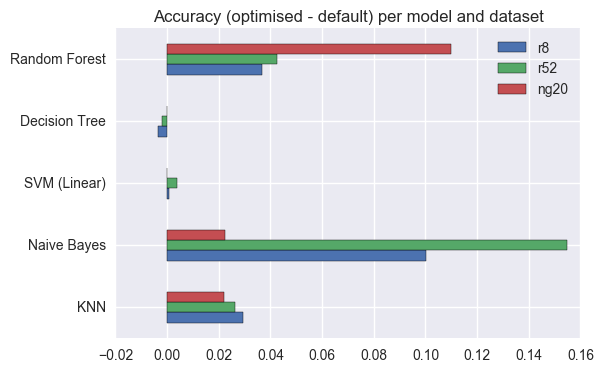

In [65]:
grid_results_df = pd.DataFrame({"r8": [result[2]-result[1] for result in r8_results_grid],
                                "r52": [result[2]-result[1] for result in r52_results_grid],
                                "ng20": [result[2]-result[1] for result in ng20_results_grid]},
                               index=[model[0] for model in optimisable_models])
grid_results_df[["r8","r52","ng20"]].plot.barh(title="Accuracy (optimised - default) per model and dataset")

From the previous plot, we can see that using GridSearchCV it was possible to improve results for some of the models.  There is no guarantee that the parameters chosen by GridSearchCV are the absolute best ones, but at least it's reassuring to see that results did not get worse for the parameter combinations that were tested.

- Results for DesisionTree and SVM changed very little, which means that default values for the parameters already work as well as possible with these datasets.
- I was impressed to see how much results improved for NaiveBayes by setting `fit_prior` to `False`.  This means that using a uniform prior for class probabilities improves results, specially when the datasets are extremely skewed (like `r8` and `r52`).
- It was interesting (although not unexpected) to see that increasing the number of estimators improves results for RandomForest (but also increases the time it takes to run).
- Increasing the number of neighbours in KNN also improves results, but different datasets have different optimal numbers of neighbours.

###  Time ML models (with best parameters) and compare results

Finally, I want to look at absolute values for Accuracy, and compare how well each model performs with each dataset (using only the best parameters for each dataset).  I also want to consider how long the models take to train and test, because in a real setting it may be better to have a slightly worse model, it is much faster.

As a side note, I should add that I timed one train and one test per model and dataset, and this is not ideal.  Many things can influence how long a model takes to train that do not depend on the model (Did the system perform a garbage collection? Are there other threads computing for CPU?), so to get more trustworthy times I should time several runs and get average times for them.

In [66]:
import time

def apply_and_time_models(models, df_train, df_test):
    """Returns a list of (model_name, accuracy, time_train, time_test)
    that results from applying each model to the train and test dataframes."""
    X_train, y_train, X_test, y_test = to_tfidf(df_train, df_test)

    result = []
    for (name, model) in models:
        t0 = time.time()
        model.fit(X_train, y_train)
        time_train = (time.time() - t0)
        
        t1 = time.time()
        y_pred = model.predict(X_test)
        time_test = (time.time() - t1)

        score = accuracy_score(y_test, y_pred)
        result.append((name, score, time_train, time_test))
    return result    

In [67]:
# Variables r8_optimised_models, r52_optimised_models, ng20_optimised_models
# from previous section contain optimised parameters and models for each dataset.
# print(r8_optimised_models)
# print(r52_optimised_models)
# print(ng20_optimised_models)

Apply the optimised models to each dataset.

In [68]:
r8_results_timed = apply_and_time_models(r8_optimised_models, r8_train_df, r8_test_df)
r8_results_timed

[(u'KNN', 0.89904065783462772, 0.007704973220825195, 1.0500991344451904),
 (u'Naive Bayes',
  0.95705801735952489,
  0.029896974563598633,
  0.0021300315856933594),
 (u'SVM (Linear)',
  0.97396071265417994,
  0.3418431282043457,
  0.002039194107055664),
 (u'Decision Tree',
  0.91411603471904979,
  1.4033761024475098,
  0.0019969940185546875),
 (u'Random Forest',
  0.93969849246231152,
  3.988234043121338,
  0.14189410209655762)]

In [69]:
r52_results_timed = apply_and_time_models(r52_optimised_models, r52_train_df, r52_test_df)
r52_results_timed

[(u'KNN', 0.86526479750778817, 0.013735055923461914, 1.4294040203094482),
 (u'Naive Bayes',
  0.88707165109034269,
  0.13129591941833496,
  0.023643016815185547),
 (u'SVM (Linear)',
  0.95327102803738317,
  2.2168028354644775,
  0.015980958938598633),
 (u'Decision Tree',
  0.84735202492211836,
  2.8843748569488525,
  0.02333688735961914),
 (u'Random Forest',
  0.86915887850467288,
  6.906268119812012,
  0.28728199005126953)]

In [70]:
ng20_results_timed = apply_and_time_models(ng20_optimised_models, ng20_train_df, ng20_test_df)
ng20_results_timed

[(u'KNN', 0.75571200850159403, 0.02213597297668457, 8.746530055999756),
 (u'Naive Bayes',
  0.8387353878852285,
  0.2265620231628418,
  0.061360836029052734),
 (u'SVM (Linear)', 0.84710414452709881, 3.79681396484375, 0.0403599739074707),
 (u'Decision Tree',
  0.57943676939426147,
  21.402995109558105,
  0.01783609390258789),
 (u'Random Forest',
  0.76833156216790643,
  40.69181704521179,
  1.0634288787841797)]

How do models compare in Accuracy?

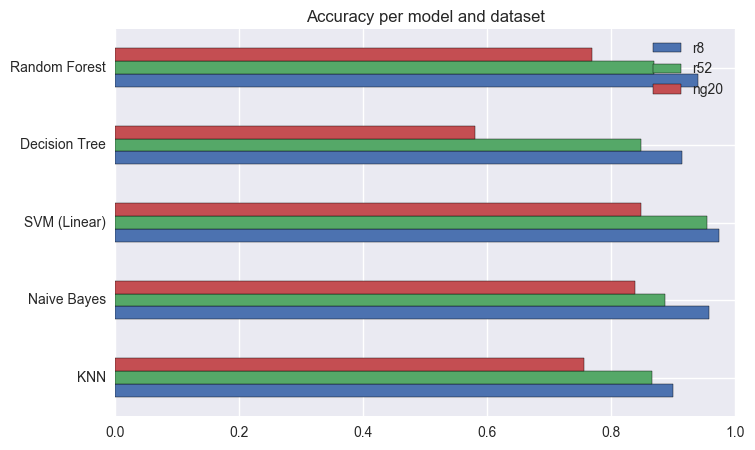

In [71]:
timed_results_acc_df = pd.DataFrame({"r8": [x[1] for x in r8_results_timed],
                                "r52": [x[1] for x in r52_results_timed],
                                "ng20": [x[1] for x in ng20_results_timed]},
                               index=[model[0] for model in r8_optimised_models])
timed_results_acc_df[["r8","r52","ng20"]].plot.barh(
    figsize=(8, 5),                                                
    title="Accuracy per model and dataset")

We can see that most optimised models perform well enough for these datasets, in particular for r8 and r52.

The best model overal continues to be SVM using a linear kernel.

Is there a dataset that is "harder" than others?

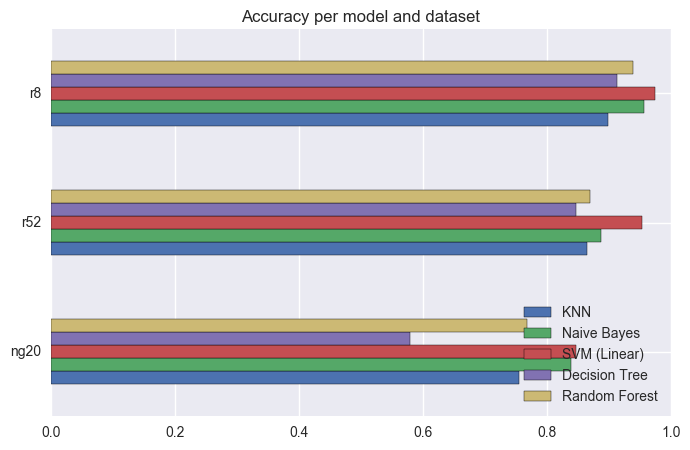

In [72]:
timed_results_acc_df.transpose().plot.barh(figsize=(8, 5), 
                                       title="Accuracy per model and dataset")

Looking at the length of these bars, we can see that ng20 is the "hardest" dataset, followed by r52 and finally r8.

How do these models compare in terms of how long they take to train and test?

(Datasets have different sizes, so agglomerate by them.)

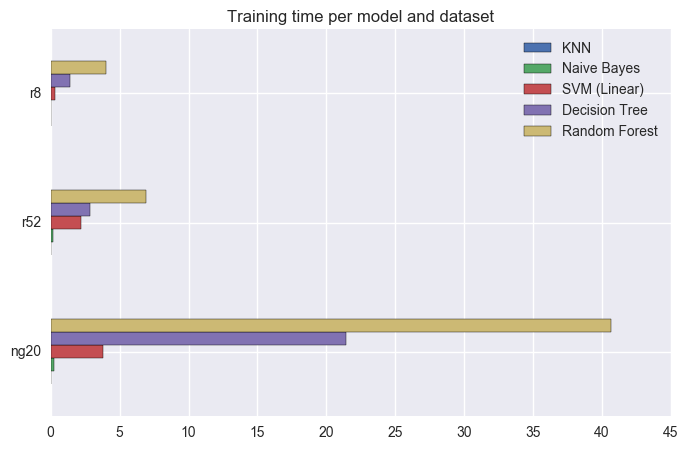

In [73]:
timed_results_train_df = pd.DataFrame({"r8": [x[2] for x in r8_results_timed],
                                "r52": [x[2] for x in r52_results_timed],
                                "ng20": [x[2] for x in ng20_results_timed]},
                               index=[model[0] for model in r8_optimised_models])
timed_results_train_df.transpose().plot.barh(figsize=(8, 5), 
                                       title="Training time per model and dataset")

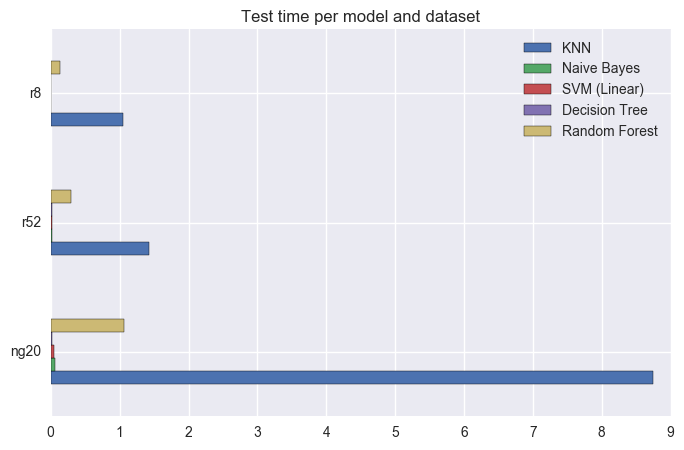

In [74]:
timed_results_test_df = pd.DataFrame({"r8": [x[3] for x in r8_results_timed],
                                "r52": [x[3] for x in r52_results_timed],
                                "ng20": [x[3] for x in ng20_results_timed]},
                               index=[model[0] for model in r8_optimised_models])
timed_results_test_df.transpose().plot.barh(figsize=(8, 5), 
                                       title="Test time per model and dataset")

Can we have all these in one plot, and look at all these results at the same time?

[]

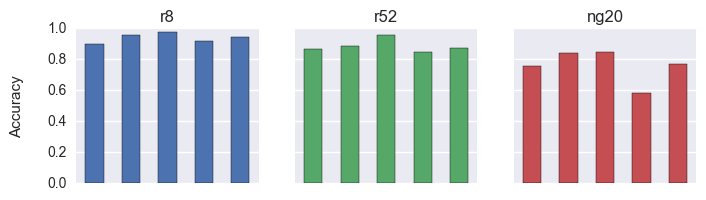

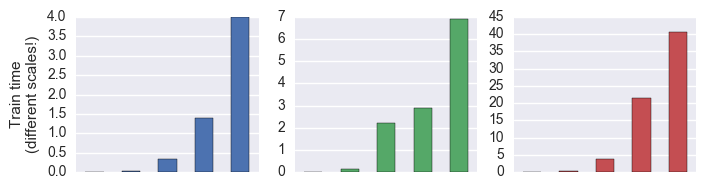

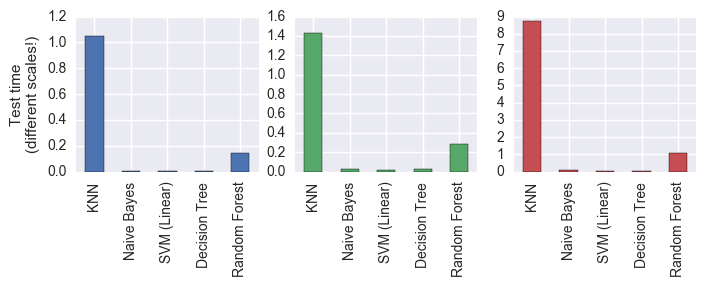

In [75]:
ax0 = timed_results_acc_df[["r8","r52","ng20"]].plot.bar(subplots=True, layout=(1,3), 
                              sharey=True, figsize=(8, 2), 
                              legend=False)
plt.xticks([])
ax0[0,0].set(ylabel="Accuracy\n")

ax1 = timed_results_train_df[["r8","r52","ng20"]].plot.bar(subplots=True, layout=(1,3), 
                                      figsize=(8, 2), legend=False)
plt.xticks([])
ax1[0,0].set(title="")
ax1[0,1].set(title="")
ax1[0,2].set(title="")
ax1[0,0].set(ylabel="Train time\n(different scales!)")

ax2 = timed_results_test_df[["r8","r52","ng20"]].plot.bar(subplots=True, layout=(1,3), 
                                     figsize=(8, 2), legend=False)
ax2[0,0].set(title="")
ax2[0,1].set(title="")
ax2[0,2].set(title="")
ax2[0,0].set(ylabel="Test time\n(different scales!)")

plt.plot()

Before starting to comment on these results, it's worth remembering that the Dumb Classifier had Accuracy values of 0.49 for `r8`, 0.42 for `r52`, and 0.05 for `ng20`.  Looking at the plots in the top row, it's easy to see that these models have much better results.

I did not say much about training and testing time before, but looking at the bottom two rows shows an interesting trend: in general, models that take longer to train (because they are creating their own representation of the dataset) will be faster to test and vice-versa.  The model that is faster to train is kNN, because it just needs to load the dataset; but every time it needs to classify a document, it needs to search the entire dataset for the closest document, so it's very slow.  I said "in general" before, because RandomForest takes longer to train than DecisionTree (because it needs to generate multiple trees), but it also takes longer to test (because it needs to take into account results from different trees), so it's the exception to the rule.

Ideally, we would like to have a model that has a very high Accuracy, but is also fast to train and (more importantly) test.  The model with highest Accuracy for all datasets is SVM.  This model is also one of the fastest to train and test.

From these results I would say that, for a single-label text classification task, if you have to choose one model to implement and optimise, choose SVM using a linear kernel.

## Summary

In the beginning of this project, I wrote that "The main goal is to reproduce part of my PhD work using state-of-the-art libraries in Python (sklearn, matplotlib, seaborn), and be able to assess how this area evolved in the past 10 years."

I think that I was able to achieve this goal, go a bit further, and there still is a lot of future work to be done.

### Approach and results

I started by loading the csv files for the three datasets, and it all went as expected.
The results of my initial analisys agree with what was previously published regarding the number of documents per class, both for training and test sets.  I also created word clouds with the 50 most common words for each dataset, and discussed some interesting aspects.

The fist thing I tried was to find in sklearn models that were "equivalent" to the ones that I used in my PhD work.  The algorithm that I used for tfidf is slightly different from the one implemented in sklearn (even after changing some parameters), so the results obtained now are different from previous results (but not too far off).  SVM using a linear kernel still was the best performing model for all datasets.

Then I tried to reproduce what in my PhD work I called "combining LSI with other models".  In sklearn, LSI is considered a feature selection algorithm and is called Singular Value Decomposition.  The main idea is the same (despite the different names).  Like before, combining LSI with SVM worsens results.  I had not combined LSI with centroids in my PhD work; here it worsens results.  In my PhD work, LSI improved results when combined with kNN (when k=1 it's also called vector model), but here this only happens for the r* datasets but not for the ng20 dataset; I imagine it's the different way to calculate tfifd that makes a difference.  In all cases, Accuracy is still below the one achieved using SVM with a linear kernel (and standard tfidf feature selection).

After that, I decided to apply some models, available in sklearn, that I had not used in my PhD work.  I was particularly interested in finding out how RandomTrees, Boosting and Ensembles would behave.  In a single sentence: SVM using a linear kernel is still the best model for all datasets.

Then, I went on by using GridSearchCV to optimise parameters for the most promising models.  The goal was to see if it was possible to outperform SVM, if I could find the best combination of parameters.  Some of the models saw their performance increase with the new parameters.  But SVM using a linear kernel still outperforms them all.

Finally, I compared Accuracy and execution times for the optimised models.  All things considered, SVM still comes on top, because even though it takes some time to learn the model (but not very long), it is very fast when asked to classify a document.

### Successes, setbacks, and lessons learned

I think that this project was successful, in that I was able to reproduce, and in some cases improve on, previous results.

My first setback was going back to my thesis and remembering what I had done.  It was not always easy to find the models in sklearn to match the models in my thesis, and in some cases both implementations had differences that I was unable to overcome, even after tweaking the parameters.  I did not go back to my Java implementation of some of the models, that would have been overwhelming at this point.

I was really happy to be able to use GridSearchCV to optimise parameters.  I implemented code to run parameter combinations at for my thesis, but then I did the "optimisation" using PivotTables in Excel.  GridSearchCV makes everything much easier.

I still do not master plotting as much as I would like to, and it was hard to decide what the last figure should look like, so that I was able to compare Accuracy and times in the same place.

### Future work

There are so many other paths that this project could have led me to, but with a limited time frame I had to make some hard choices.  I think the line of thought that I explored was interesting, but I could also have chosen to:

- Find more models in sklearn to implement and optimise.  Maybe this would have led to finding a model that was better than SVM.
- Find more datasets to test the available models.  Maybe different models were better suited to use with different languages.
- Explore different algorithms for feature selection, and try out combinations between feature selection parameters and models.
- Use larger parameter grids for GridSearchCV.
- Use other evaluation metrics besides Accuracy, like Precision, Recall, F1, etc.  I chose to use a single measure because it's the most widely used success measure for single-label text classification tasks, and results are easy to intuitively understand.
- Use Amazon Web Services (AWS) to be able to try more models or bigger datasets.  This is a task that can be easily parallelisable, because different datasets can be tested independently.  Then all results can be collected and processed as a whole.

I will definitively do some of these in the future.

## Blog post summary

Blog post here:

https://acardocacho.github.io/capstone/